# Figure 4: Increased sea ice motion driven by ocean current

Plot of the seasonal climatology of sea ice motion, for years 2008-2011.

In [1]:
import sys
sys.path.insert(0, '/g/data/gh9/wgh581/Python_code/plot_code/metroms_code')
import os
from netCDF4 import *
from numpy import *
import copy
import cmocean.cm as cmo
from matplotlib.pyplot import *
import matplotlib.gridspec as gridspec
from fxn_rotate_vector_cice import rotate_vector_cice
from fxn_rotate_vector_roms import rotate_vector_roms
import xarray as xr

Import grid info and sea ice velocity

In [2]:
path = '/g/data/gh9/wgh581/ROMS_Output/metroms_files/'

CICE

In [3]:
# Grid info from raw cice file
dim_cice = xr.open_dataset(path + 'RAW/metroms_CONTROL/cice/history/' + 'iceh.2010-01-05.nc')

In [4]:
# Sea ice area (for masking)
aice_extmin = 0.15
aice_cntr = xr.open_dataset(path + 'POST_PROCESS/aice_hi_CONTROL_2002_2011_full_circumpolar.nc').aice.sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
aice_pert = xr.open_dataset(path + 'POST_PROCESS/aice_hi_2SSFLUX_2002_2011_full_circumpolar.nc').aice.sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

In [5]:
# Sea ice velocity
vel_cntr = xr.open_dataset(path + 'POST_PROCESS/uvel_vvel_CONTROL_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
vel_pert = xr.open_dataset(path + 'POST_PROCESS/uvel_vvel_2SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

In [6]:
# Rotate velocities
uvel_cice_cntr, vvel_cice_cntr = rotate_vector_cice(vel_cntr.uvel, vel_cntr.vvel, dim_cice.ANGLE)
uvel_cice_pert, vvel_cice_pert = rotate_vector_cice(vel_pert.uvel, vel_pert.vvel, dim_cice.ANGLE)

In [7]:
# Mask for sea ice area
uvel_cice_cntr = uvel_cice_cntr.where(aice_cntr > aice_extmin, np.nan)
vvel_cice_cntr = vvel_cice_cntr.where(aice_cntr > aice_extmin, np.nan)
uvel_cice_pert = uvel_cice_pert.where(aice_pert > aice_extmin, np.nan)
vvel_cice_pert = vvel_cice_pert.where(aice_pert > aice_extmin, np.nan)

In [8]:
# Speed
speed_cice_cntr = np.sqrt(uvel_cice_cntr**2 + vvel_cice_cntr**2)
speed_cice_pert = np.sqrt(uvel_cice_pert**2 + vvel_cice_pert**2)

ROMS

In [9]:
# ROMS grid for plotting
roms = xr.open_dataset('/g/data/gh9/wgh581/ROMS_Output/metroms_files/' + 'RAW/metroms_CONTROL/' + 'ocean_his_0042.nc')
lat_roms = roms.lat_rho[:-15,:-1]
lon_roms = roms.lon_rho[:-15,:-1]
zice     = roms.zice[:-15,:-1]
h        = roms.h[:-15,:-1]
mask     = roms.mask_rho[:-15,:-1]
angle_roms = roms.angle[:-15,:-1]

# Masking
h     = np.ma.masked_where(mask==0, h)
zice  = np.ma.masked_where(mask==0, zice)
zice  = np.ma.masked_where(zice==0, zice)
lat_r = np.ma.masked_where(mask==1, lat_roms)

Plotting info

In [10]:
# Region range
xlim_min = -25
xlim_max = 15
ylim_min = -30
ylim_max = 7

In [11]:
# Spherical coordinates
deg2rad_val = pi/180.0
# CICE
x_cice = -(dim_cice.TLAT+90)*cos(dim_cice.TLON*deg2rad_val+pi/2)
y_cice = (dim_cice.TLAT+90)*sin(dim_cice.TLON*deg2rad_val+pi/2)
# ROMS
x_roms = -(lat_roms+90)*cos(lon_roms*deg2rad_val+pi/2)
y_roms = (lat_roms+90)*sin(lon_roms*deg2rad_val+pi/2)

In [12]:
# Center of missing circle (ROMS)
lat_c   = -83
lon_c   = 50
# Radius of missing circle (play around with this until it works)
radius  = 10.1
# Find center in spherical coordinates
x_c_metroms = -(lat_c+90)*np.cos(lon_c*deg2rad_val+np.pi/2)
y_c_metroms =  (lat_c+90)*np.sin(lon_c*deg2rad_val+np.pi/2)
# Build a regular x-y grid and select the missing circle
lat_max = -63+90
x_reg, y_reg = np.meshgrid(np.linspace(-lat_max, lat_max, num=1000), np.linspace(-lat_max, lat_max, num=1000))
land_circle  = np.zeros(np.shape(x_reg))
land_circle_metroms = np.ma.masked_where(np.sqrt((x_reg-x_c_metroms)**2 + (y_reg-y_c_metroms)**2) > radius, land_circle)

In [13]:
season = ['Summer', 'Autumn', 'Winter', 'Spring']
panel_name = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', \
        'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)', 'p)']
# Figure saving info
ft_size = 14
my_dpi  = 150
fig_path = '/g/data/gh9/wgh581/Python_code/MetROMS_BasalMelt_Perturbation/figures/'

In [14]:
# # Colormap
# from palettable.scientific.diverging import Vik_19_r 
# from palettable.scientific.sequential import LaPaz_3_r
# from palettable.colorbrewer.diverging import PRGn_5_r

In [14]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# Colormap
from palettable.scientific.diverging import Vik_19_r 
from palettable.scientific.diverging import Vik_19

Test = cm.get_cmap(Vik_19_r.mpl_colormap, 512)
newcmp = ListedColormap(Test(np.linspace(0.25, 0.75, 256)))

Vik_19_r_blues = ListedColormap(Test(np.linspace(0.5, 1, 256)))

/jobfs/99309042.gadi-pbs/ipykernel_2635540/3537576840.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  Test = cm.get_cmap(Vik_19_r.mpl_colormap, 512)


In [15]:
import matplotlib as mpl
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
            normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
            normalized_mid = 0.5
            x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
            return np.ma.masked_array(np.interp(value, x, y))
norm = MidpointNormalize(vmin=0, vmax=0.2, midpoint=0.05)

In [16]:
# To add longitude lines to plot
y_30SE = xlim_max * tan(60*deg2rad_val+pi/2)
y_60SE = xlim_max * tan(30*deg2rad_val+pi/2)

y_30NW = xlim_min * tan(60*deg2rad_val+pi/2)
y_60NW = xlim_min * tan(30*deg2rad_val+pi/2)

x_30NE = -ylim_max / tan(30*deg2rad_val+pi/2)

y_30SW = -xlim_min * tan(30*deg2rad_val+pi/2)
y_60SW = -xlim_min * tan(60*deg2rad_val+pi/2)

# To add latitude lines to plot (75S is not defined everywhere on model grid)
# Center (south pole)
lat_c   = -90
lon_c   = 0
# Find center in spherical coordinates
x_c_metroms_0 = -(lat_c+90)*np.cos(lon_c*deg2rad_val+np.pi/2)
y_c_metroms_0 = (lat_c+90)*np.sin(lon_c*deg2rad_val+np.pi/2)
# Build a regular x-y grid and select the missing circle
lat_max = -63+90
land_circle_tmp = np.zeros(np.shape(x_reg))
land_circle_75 = np.where(np.sqrt((x_reg-x_c_metroms_0)**2 + \
                      (y_reg-y_c_metroms_0)**2) > 15, land_circle_tmp, 1)

def plot_lat_lon_grid():
    # Add longitude lines
    plot([0, 0], [ylim_max, ylim_min], color='0.8', linewidth=0.5, linestyle='--')
    plot([xlim_min, xlim_max], [0, 0], color='0.8', linewidth=0.5, linestyle='--')
    # SE
    plot([0, xlim_max], [0, y_30SE], color='0.8', linewidth=0.5, linestyle='--')
    plot([0, xlim_max], [0, y_60SE], color='0.8', linewidth=0.5, linestyle='--')
    # NW
    plot([xlim_min, 0], [y_30NW, 0], color='0.8', linewidth=0.5, linestyle='--')
    plot([xlim_min, 0], [y_60NW, 0], color='0.8', linewidth=0.5, linestyle='--')
    # NE
    plot([0, x_30NE], [0, ylim_max], color='0.8', linewidth=0.5, linestyle='--')
    plot([0, xlim_max], [0, -1*y_30SE], color='0.8', linewidth=0.5, linestyle='--')
    # SW
    plot([xlim_min, 0], [y_30SW, 0], color='0.8', linewidth=0.5, linestyle='--')
    plot([xlim_min, 0], [y_60SW, 0], color='0.8', linewidth=0.5, linestyle='--')
    # Labels of longitude lines
    text(0, ylim_min+1, '180°E', fontsize=ft_size-4, ha='center', va='center', color='0.8')
    text(0, ylim_max-1.5, '0°E', fontsize=ft_size-4, ha='center', va='center', color='0.8')
    text(xlim_max-3, 0, '90°E', fontsize=ft_size-4, ha='center', va='center', color='0.8')
    text(xlim_min+4, 0, '270°E', fontsize=ft_size-4, ha='center', va='center', color='0.8')
    # Add latitude lines
    contour(x_cice, y_cice, dim_cice.TLAT, levels=[-60], colors='0.8', linewidths=0.5, linestyles='--')
    contour(x_reg, y_reg, land_circle_75, levels=1, colors='0.8', linewidths=0.5, linestyles='--')
    # Labels of latitude lines
    text(-9, -9, '75°S', fontsize=ft_size-4, ha='center', va='center', color='0.8')
    text(-21.5, -17, '60°S', fontsize=ft_size-4, ha='center', va='center', color='0.8')

/jobfs/88861765.gadi-pbs/ipykernel_3938043/1292888238.py:21: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_cice, y_cice, speed_cice_cntr[tt,:,:], cmap=Vik_19_r_blues, norm=norm)
/jobfs/88861765.gadi-pbs/ipykernel_3938043/1292888238.py:44: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  SC = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-0.1, vmax=0.1)
/jobfs/88861765.gadi-pbs/ipykernel_3938043/1292888238.py:21: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. Thi

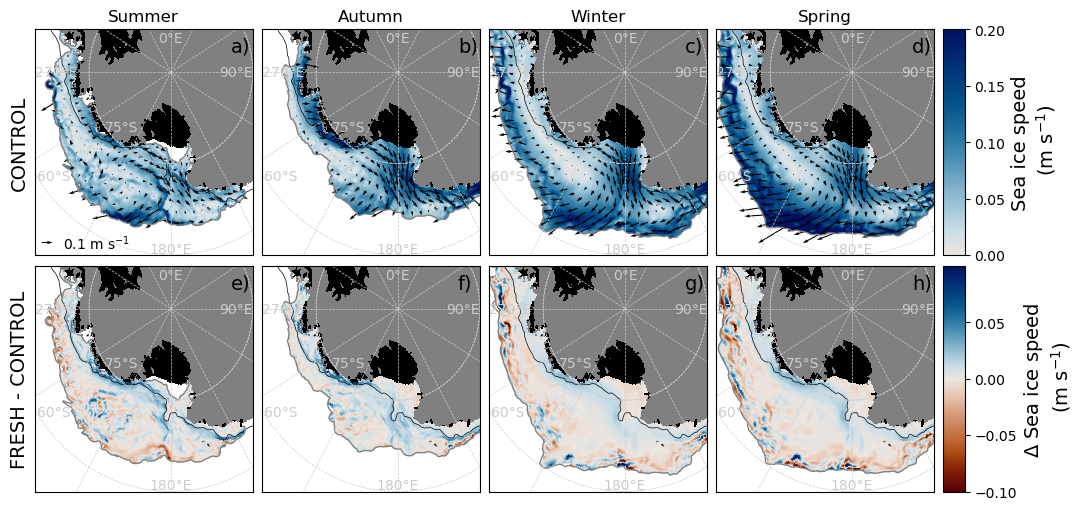

In [84]:
# Sea ice motion
fig = figure(figsize=(12,6))

gs  = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('CONTROL', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    sc = pcolormesh(x_cice, y_cice, speed_cice_cntr[tt,:,:], cmap=Vik_19_r_blues, norm=norm)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice_cntr[tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    Q = quiver(x_cice[::15,::15], y_cice[::15,::15], -uvel_cice_cntr[tt,::15,::15], -vvel_cice_cntr[tt,::15,::15], scale=2, width=0.005)
    if tt == 0:
        #quiverkey(Q, 0.15, 0.65, 0.1, r'0.1 m s$^{-1}$', labelpos='E', coordinates='figure')
        quiverkey(Q, 0.14, 0.525, 0.1, r'0.1 m s$^{-1}$', labelpos='E', coordinates='figure')
    plot_lat_lon_grid()
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # PERT-CNTR
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('FRESH - CONTROL', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    diff = speed_cice_pert[tt,:,:] - speed_cice_cntr[tt,:,:]
    SC = pcolormesh(x_cice, y_cice, diff, cmap=Vik_19_r.mpl_colormap, vmin=-0.1, vmax=0.1)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice_cntr[tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    plot_lat_lon_grid()
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)


# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0, ticks=np.arange(0, 0.25, 0.05))
cbar.set_label('Sea ice speed\n (m s$^{-1}$)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(SC, cax=cbar_ax1, ticks=np.arange(-0.1, 0.1, 0.05))
cbar.set_label('$\Delta$ Sea ice speed \n (m s$^{-1}$)', fontsize=ft_size)


# Finished
plot_flag = 1
if plot_flag == 1:
    fig_name = 'Figure4_2SSFLUX_gridlines.png'
    savefig(fig_path + fig_name, dpi=my_dpi, bbox_inches='tight', facecolor='white')

#### Figure S4: surface ocean temp and speed

In [17]:
# Ocean velocity
vel_roms_cntr = xr.open_dataset(path + 'POST_PROCESS/ocean_u_v_CONTROL_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
vel_roms_pert = xr.open_dataset(path + 'POST_PROCESS/ocean_u_v_2SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))


In [18]:
# Ocean SST
sst_roms_cntr = xr.open_dataset(path + 'POST_PROCESS/ocean_SST_CONTROL_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).temp
sst_roms_pert = xr.open_dataset(path + 'POST_PROCESS/ocean_SST_2SSFLUX_2002_2011_full_circumpolar.nc').sel(time=slice('2008-12-01','2011-11-30')).groupby('time.season').mean('time').sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).temp


In [19]:
def get_roms_velocity_on_rho_grid(expt_name):
    
    speed_tmp    = np.zeros((4, np.size(angle_roms,0), np.size(angle_roms,1)))
    u_lonlat_tmp = np.zeros((4, np.size(angle_roms,0), np.size(angle_roms,1)))
    v_lonlat_tmp = np.zeros((4, np.size(angle_roms,0), np.size(angle_roms,1)))
    
    for tt in range(4):
        # Rotate velocity vectors
        u_rot_tmp, v_rot_tmp = rotate_vector_roms(expt_name.u[0,:-15,:-1].values, expt_name.v[0,:-15,:-1].values, angle_roms)
        # Calculate magnitude of ocean velocity
        speed_tmp[tt,:,:] = np.sqrt(u_rot_tmp**2 + v_rot_tmp**2)
        # Write u_lonlat, v_lonlat
        u_rot_tmp[zice!=0] = np.nan
        v_rot_tmp[zice!=0] = np.nan
        u_lonlat_tmp[tt,:,:] = u_rot_tmp
        v_lonlat_tmp[tt,:,:] = v_rot_tmp
        # Masking
        speed_tmp[:,1:-1,1:-1][aice_cntr[:-15,:-1] < aice_extmin] = np.nan
        v_lonlat_tmp[:,1:-1,1:-1][aice_cntr[:-15,:-1] < aice_extmin] = np.nan
        u_lonlat_tmp[:,1:-1,1:-1][aice_cntr[:-15,:-1] < aice_extmin] = np.nan
        # Set values over 0.3 m/s to nan 
        # (Values around ice shelf front are very large, this cut shouldn't remove 
        #  values we are actually interested in.)
        v_lonlat_tmp[u_lonlat_tmp > 0.3] = np.nan
        u_lonlat_tmp[u_lonlat_tmp > 0.3] = np.nan
        u_lonlat_tmp[v_lonlat_tmp > 0.3] = np.nan
        v_lonlat_tmp[v_lonlat_tmp > 0.3] = np.nan
    
    return u_lonlat_tmp, v_lonlat_tmp, speed_tmp



In [20]:
u_roms_cntr, v_roms_cntr, speed_roms_cntr = get_roms_velocity_on_rho_grid(vel_roms_cntr)
u_roms_pert, v_roms_pert, speed_roms_pert = get_roms_velocity_on_rho_grid(vel_roms_pert)


To add cross-slope sections of Fig S5 to plot

In [22]:
# Along longitudes (code for cross-section does not seem to work properly)
lon_start = [169, 227]
lon_end   = [169, 227]
lat_start = [-71.5, -75]
lat_end   = [-68.5, -72]

# Create array
lon_sec   = array((lon_start,lon_end))
lat_sec   = array((lat_start,lat_end))

# Convert to spherical coordinates
deg2rad = pi/180.0
x_sec    = -(lat_sec+90) * cos(lon_sec*deg2rad+pi/2)
y_sec    =  (lat_sec+90) * sin(lon_sec*deg2rad+pi/2)

Plotting

/jobfs/99309042.gadi-pbs/ipykernel_2635540/4180362090.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_roms, y_roms, diff, cmap=Vik_19_r.mpl_colormap, vmin=-0.1, vmax=0.1)
/jobfs/99309042.gadi-pbs/ipykernel_2635540/4180362090.py:48: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  SC = pcolormesh(x_roms, y_roms, diff, cmap=Vik_19.mpl_colormap, vmin=-0.2, vmax=0.2)


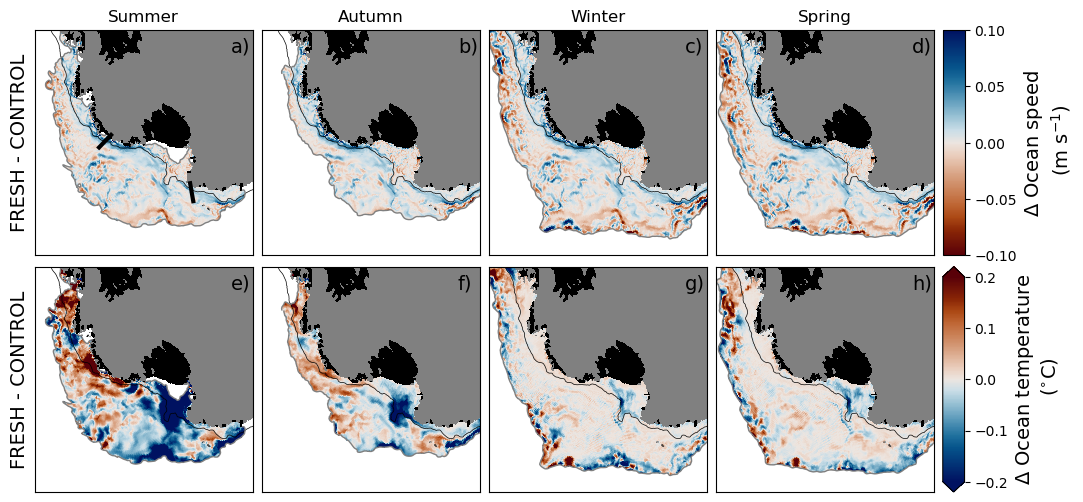

In [26]:
# Sea ice motion
fig = figure(figsize=(12,6))

gs  = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('FRESH - CONTROL', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    diff = speed_roms_pert[tt,:,:] - speed_roms_cntr[tt,:,:]
    diff[1:-1,1:-1][aice_cntr[tt,:-15,:-1] < aice_extmin] = np.nan
    sc = pcolormesh(x_roms, y_roms, diff, cmap=Vik_19_r.mpl_colormap, vmin=-0.1, vmax=0.1)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice_cntr[tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    # plot_lat_lon_grid()
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)
    # Plot sections
    if tt == 0:
        for i in range(size(x_sec,1)):
            number = i+1
            plot(x_sec[:,i], y_sec[:,i], color='k', linewidth=3)

    # PERT-CNTR
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('FRESH - CONTROL', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    diff = sst_roms_pert[tt,:-15,:-1].values - sst_roms_cntr[tt,:-15,:-1].values
    diff[1:-1,1:-1][aice_cntr[tt,:-15,:-1] < aice_extmin] = np.nan
    SC = pcolormesh(x_roms, y_roms, diff, cmap=Vik_19.mpl_colormap, vmin=-0.2, vmax=0.2)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice_cntr[tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    # plot_lat_lon_grid()
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)


# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.1, 0.11, 0.05))
cbar.set_label('$\Delta$ Ocean speed \n (m s$^{-1}$)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(SC, cax=cbar_ax1, ticks=np.arange(-0.2, 0.25, 0.1), extend='both')
cbar.set_label('$\Delta$ Ocean temperature\n ($^{\circ}$C)', fontsize=ft_size)

# Finished
plot_flag = 1
if plot_flag == 1:
    fig_name = 'FigureS4.png'
    savefig(fig_path + fig_name, dpi=my_dpi, bbox_inches='tight', facecolor='white')

### Compare ocean and sea ice velocity in CONTROL

/jobfs/99073512.gadi-pbs/ipykernel_3443275/1776170324.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  sc = pcolormesh(x_roms, y_roms, diff, cmap=Vik_19_r_blues, vmin=0, vmax=0.2)
/jobfs/99073512.gadi-pbs/ipykernel_3443275/1776170324.py:45: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  SC = pcolormesh(x_roms[:,:-1], y_roms[:,:-1], diff, cmap=Vik_19.mpl_colormap, vmin=-0.2, vmax=0.2)


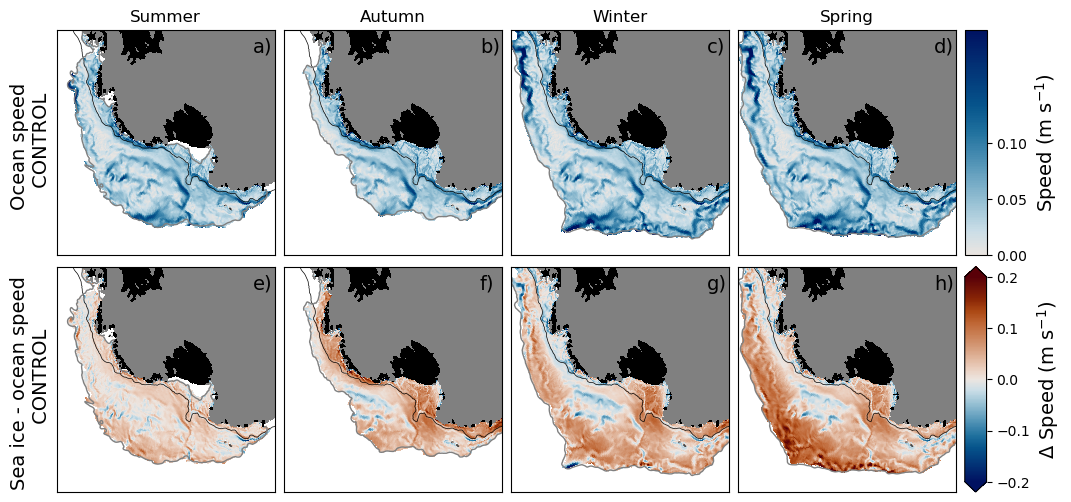

In [53]:
# Sea ice motion
fig = figure(figsize=(12,6))

gs  = gridspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.05)
gs0 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[0], wspace=0.05)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 5, width_ratios=[1,1,1,1,0.1], \
        subplot_spec=gs[1], wspace=0.05)

for tt in range(len(season)):

    # CNTR
    ax = fig.add_subplot(gs0[0,tt])
    ax.text(0.9, 0.9, panel_name[tt], fontsize=ft_size, transform=ax.transAxes)
    title(season[tt])
    if tt == 0:
        ylabel('Ocean speed \n CONTROL', fontsize=ft_size)
    setp(ax.get_yticklabels(), visible=False)
    setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    #diff = speed_roms_pert[tt,:,:] - speed_roms_cntr[tt,:,:]
    #diff[1:-1,1:-1][aice_cntr[tt,:-15,:-1] < aice_extmin] = np.nan
    #sc = pcolormesh(x_roms, y_roms, diff, cmap=Vik_19_r.mpl_colormap, vmin=-0.1, vmax=0.1)
    diff = speed_roms_pert[tt,:,:]
    diff[1:-1,1:-1][aice_pert[tt,:-15,:-1] < aice_extmin] = np.nan
    sc = pcolormesh(x_roms, y_roms, diff, cmap=Vik_19_r_blues, vmin=0, vmax=0.2)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice_cntr[tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)

    # PERT-CNTR
    ax = fig.add_subplot(gs1[0,tt])
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('Sea ice - ocean speed \n CONTROL', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    diff = speed_cice_pert[tt,:-13,:].values - speed_roms_pert[tt,:,:-1]
    diff[aice_pert[tt,:-13,:] < aice_extmin] = np.nan
    SC = pcolormesh(x_roms[:,:-1], y_roms[:,:-1], diff, cmap=Vik_19.mpl_colormap, vmin=-0.2, vmax=0.2)
    # SC = pcolormesh(x_cice, y_cice, speed_cice_pert[tt,:,:], cmap=Vik_19_r_blues, norm=norm)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice_cntr[tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)


# Add colorbars
cbar_ax0 = fig.add_subplot(gs0[:,-1])
cbar = colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.1, 0.11, 0.05))
cbar.set_label('Speed (m s$^{-1}$)', fontsize=ft_size)
cbar_ax1 = fig.add_subplot(gs1[:,-1])
cbar = colorbar(SC, cax=cbar_ax1, ticks=np.arange(-0.2, 0.25, 0.1), extend='both')
cbar.set_label('$\Delta$ Speed (m s$^{-1}$)', fontsize=ft_size)

In [38]:
np.shape(speed_cice_pert[:,:-13,:])

(4, 415, 1440)

In [35]:
np.shape(speed_roms_pert[:,:,:-1])

(4, 415, 1440)

In [40]:
np.shape(aice_cntr)

(4, 428, 1440)

In [43]:
np.shape(diff[1:-1,1:-1])

(413, 1438)

In [45]:
np.shape(x_roms)

(415, 1441)

/jobfs/99073512.gadi-pbs/ipykernel_3443275/2641120863.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  SC = pcolormesh(x_roms[:,:-1], y_roms[:,:-1], diff, cmap=Vik_19.mpl_colormap, vmin=-0.2, vmax=0.2)


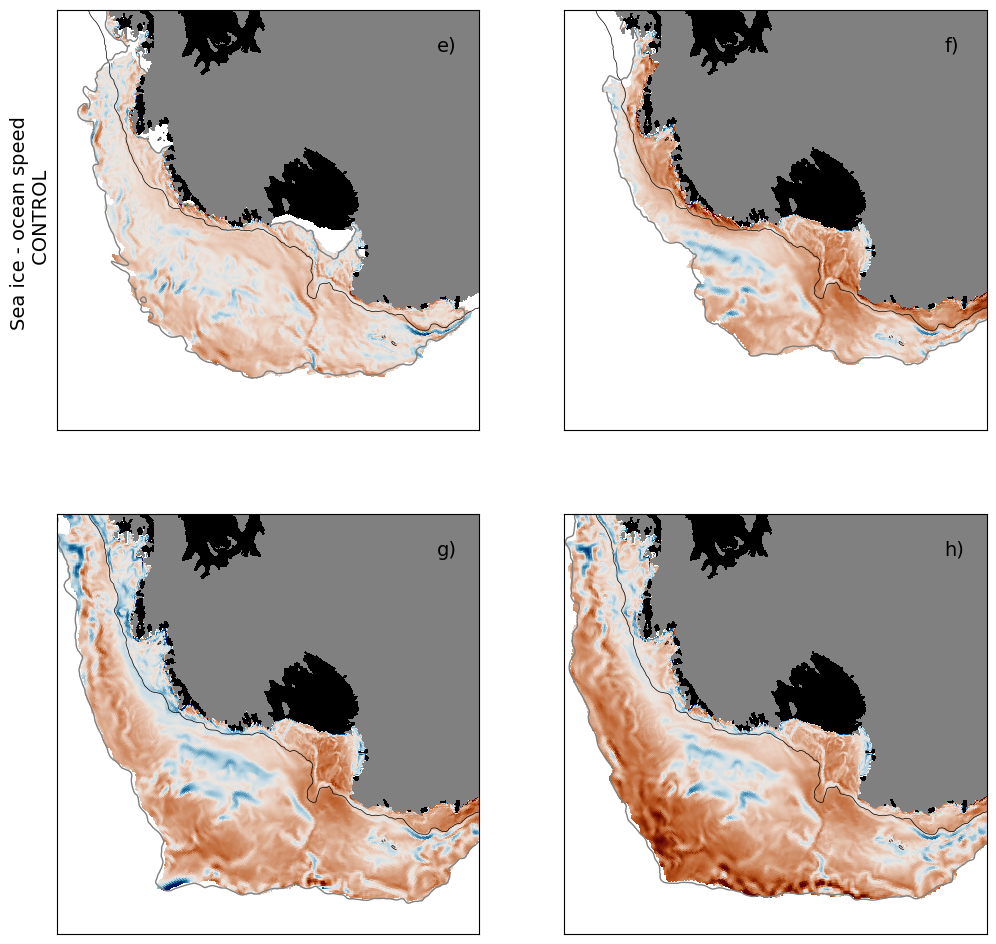

In [54]:
# Sea ice motion
fig = figure(figsize=(12,12))

for tt in range(len(season)):

    # PERT-CNTR
    ax = fig.add_subplot(2,2,tt+1)
    ax.text(0.9, 0.9, panel_name[tt+4], fontsize=ft_size, transform=ax.transAxes)
    if tt == 0:
        ylabel('Sea ice - ocean speed \n CONTROL', fontsize=ft_size)
    setp(ax.get_xticklabels(), visible=False)
    setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    diff = speed_cice_pert[tt,:-13,:].values - speed_roms_pert[tt,:,:-1]
    diff[aice_pert[tt,:-13,:] < aice_extmin] = np.nan
    SC = pcolormesh(x_roms[:,:-1], y_roms[:,:-1], diff, cmap=Vik_19.mpl_colormap, vmin=-0.2, vmax=0.2)
    # SC = pcolormesh(x_cice, y_cice, speed_cice_pert[tt,:,:], cmap=Vik_19_r_blues, norm=norm)
    contourf(x_reg, y_reg, land_circle_metroms, colors='0.5')
    contourf(x_roms, y_roms, lat_r, colors='0.5')
    contourf(x_roms, y_roms, zice*1, colors='k')
    contour(x_roms, y_roms, h, levels=[1000], colors='k', linewidths=0.5)
    contour(x_cice, y_cice, aice_cntr[tt,:,:], levels=[aice_extmin], colors='0.5', linewidths=1)
    xlim(xlim_min, xlim_max)
    ylim(ylim_min, ylim_max)


# # Add colorbars
# cbar_ax0 = fig.add_subplot(gs0[:,-1])
# cbar = colorbar(sc, cax=cbar_ax0, ticks=np.arange(-0.1, 0.11, 0.05))
# cbar.set_label('Speed (m s$^{-1}$)', fontsize=ft_size)
# cbar_ax1 = fig.add_subplot(gs1[:,-1])
# cbar = colorbar(SC, cax=cbar_ax1, ticks=np.arange(-0.2, 0.25, 0.1), extend='both')
# cbar.set_label('$\Delta$ Speed (m s$^{-1}$)', fontsize=ft_size)